<a href="https://colab.research.google.com/github/michalmash/Helicopter-Game/blob/master/fer_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Present by : Tamar Nissim (315249599) & Michal Mashiach (322276023) 

# **Intro**

### Are you able to recognize facial expressions?

Do you notice that the person standing in front of you is scared or happy?

Humans are accustomed to receiving non-verbal cues from facial emotions.
The task of identifying facial expressions is is quite easy for a human, but it may be a bit challenging for a predictive algorithm because the images have a low resolution,
the faces are not in the same position,
some images have text written on them,
some people hide part of their faces with their hands,
However all this diversity of images will contribute to make a more generalizable model. 

Can you guess which images are related to which expressions?
Now computers are also getting better at reading emotions. 


### So how do we identify emotions in a picture?
### And what is it useful to us? 



The facial recognition technology has many uses like providing security whereas the facial expression recognition technology will be useful for detection of truthfulness or potential deception. 
This is of great use for the police department for solving a crime. The police can analyze if the eyewitness or the suspect is lying which is very useful in analyzing the crime scene . By using this technology, it gets easy to know persons way of thinking and his interest in various aspects which will be very advantageous for various companies for improving their sales. Facial expressions and other gestures are very important in the nonverbal communication which plays a major role in interpersonal relations. So, facial expression recognition, as it extracts and analyzes the information taken from the images or videos, it will be able to deliver the exact or the unbiased emotional responses as data. We achieve the facial recognition by detecting the faces and by analyzing the movement of our eyes, nose, lips etc. and analyzing changes in the appearance of the facial features and classifying various expressions. 

# **Our goal💪**

Our goal is **to categorize each face** based on the emotion shown in the facial expression into one of seven categories :

### Angry, Disgust, Fear, Happy, Sad, urprise, Neutral.

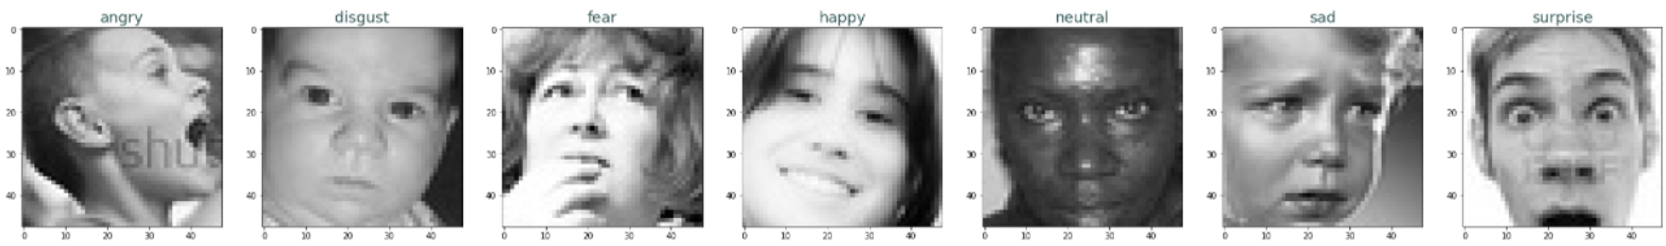

# **First, let's see the data set we will use:**

# Our data set:

The data consists of 48x48 pixel grayscale images of faces. 

The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

 The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

### **The photos are located in our private drive, we will import them**

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!ls gdrive/MyDrive
!unzip drive/MyDrive/faceimage.zip

**Install Libraries**

In [ ]:
!pip install torchdata
!pip install imblearn

**Import Libraries**

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as image

from pprint import pprint

%matplotlib inline

In [5]:
# below variables are established to be used throughout the notebook without being subjected to any change
BATCH_SIZE     = 64
HEIGHT = WIDTH = 48
CHANNELS       =  3

EMOTIONS       = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

In [6]:
import os
import re

import numpy as np
import pandas as pd

import cv2
import PIL.Image as Image

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from torchvision import transforms

In [7]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

**We will load the data, as a DataFrame**

Database is already divided into test and train in the emotion named folders but it is required to have label data to start working. While doing this, all the data has been combined under unique set which will be seperated later according to the 20/80 rule.

A sample of each emotion is illustrated by looping through each emotion sub-folder and looking up the first image to plot as an example. Each example image is annotated with the emotion label assigned to it.



In [8]:
paths   = []
labels  = []

base = f"/content/FACE/face/"

if os.path.exists(path=base) and os.path.isdir(base):
    for level_1_dir in os.listdir(path=base): # train/test
        level_1_path = f"{level_1_dir}"
        if os.path.exists(path=base + level_1_path) and os.path.isdir(base + level_1_path):
            for level_2_dir in os.listdir(path=base + level_1_path): # 7 emotions
                level_2_path =f"{level_1_path}/{level_2_dir}"
                if os.path.exists(path=base + level_2_path) and os.path.isdir(base + level_2_path):
                    for file in os.listdir(path=base + level_2_path): # files
                        file_path = f"{level_2_path}/{file}"
                        if os.path.isfile(base + file_path):
                            paths.append(file_path)
                            labels.append(level_2_dir)

df = pd.DataFrame({'path': [base + path for path in paths], 'label': labels})

**create a new column to store the images as ndarray**

In [9]:
df['img_as_matrix'] = df['path'].apply(lambda path: cv2.imread(path))

In [10]:
# keep the non clean data before we clean it
X_orginal = np.stack(df['img_as_matrix'].copy())
y_orginal = df['label'].copy()

**view first 5 rows of the newly created dataframe**

In [11]:
df.head()

,path,label,img_as_matrix
0,/content/FACE/face/train/angry/Training_980760...,angry,"[[[107, 107, 107], [111, 111, 111], [120, 120,..."
1,/content/FACE/face/train/angry/Training_955648...,angry,"[[[117, 117, 117], [128, 128, 128], [139, 139,..."
2,/content/FACE/face/train/angry/Training_788963...,angry,"[[[94, 94, 94], [80, 80, 80], [83, 83, 83], [8..."
3,/content/FACE/face/train/angry/Training_295256...,angry,"[[[150, 150, 150], [88, 88, 88], [102, 102, 10..."
4,/content/FACE/face/train/angry/Training_794049...,angry,"[[[1, 1, 1], [3, 3, 3], [0, 0, 0], [0, 0, 0], ..."


### We will classify each image based on the emotion shown in the facial expression into one of 7 categories.

**Representative sample from each category:**

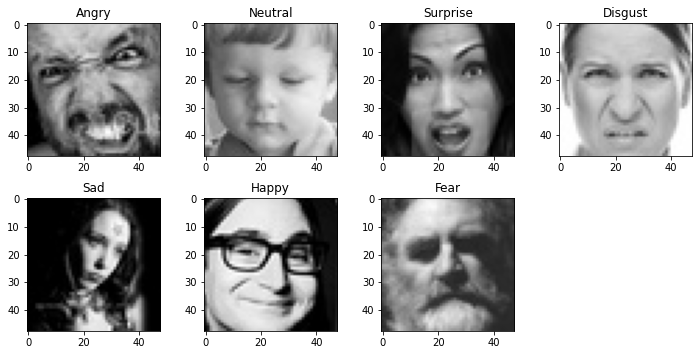

In [13]:
# set plotting options
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)

for index, label in enumerate(df['label'].unique()):
    img = df[df['label'] == label]['img_as_matrix'].iloc[0]
    
    exec(f"ax{index + 1}.imshow(img)")
    exec(f"ax{index + 1}.set_title(label.title())")
    
fig.tight_layout()

# **EDA**

Depending on how over- or under-represented some emotions are, the model can learn a skewed pattern and hence, not generalize well enough when it comes to test data. For instance, in the cell below, we're plotting the number of images per emotion class to understand the underlying distribution. As can be observed, the representation of different classes is dramatically different from others: e.g., disgust is under-represented, while happy is over-represented. This means that our model can be skewed in its predictions due to such discrepancies and hence, imbalance will have to be handled.




<BarContainer object of 7 artists>

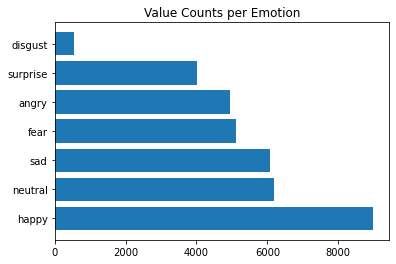

In [14]:
plt.title('Value Counts per Emotion')
plt.barh(y = df.label.value_counts().index, width = df.label.value_counts().values)

# **Handling exceptional values**



There are images that are far off from the way an average image looks like in an emotion category. To solve this, we find an average image per emotion class, compute the mean error for each image and find whether the mean error is within standard deviation limits. If the mean error is below or above the standard deviation boundaries, then we consider the image as anomalous and drop it.
We perform this for the whole dataset, before splitting it into train / holdout.
In the future, we plan to apply augmentations to images to increase their quality / contrast. For example, adding salt and pepper noise to the train dataset will help to train the model to predict more or less accurately on the bad holdout images.

## **We find an average image per emotion class**

In this section, an average image per emotion class is displayed.
 The average image is computed by adding together the array representations of each image in the emotion sub-folder and dividing that sum by the total number of images in the sub-folder to find the mean.

The resulting average images per emotion class are then displayed.




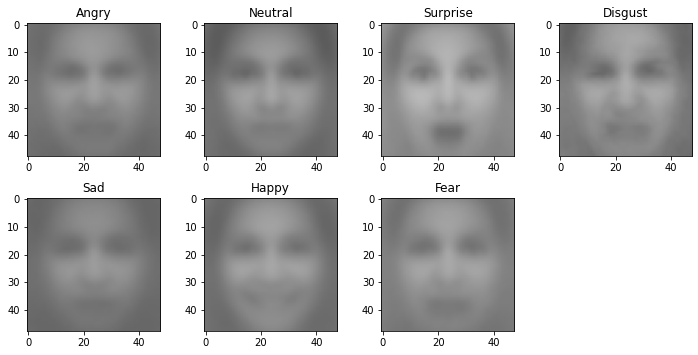

In [15]:
# setplotting options
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)
for index, label in enumerate(df['label'].unique()):
    avg_img = np.stack(df[df['label'] == label]['img_as_matrix']).mean(axis=0).astype(np.uint8)
    
    exec(f"ax{index + 1}.imshow(avg_img)")
    exec(f"ax{index + 1}.set_title(label.title())")
    
fig.tight_layout()

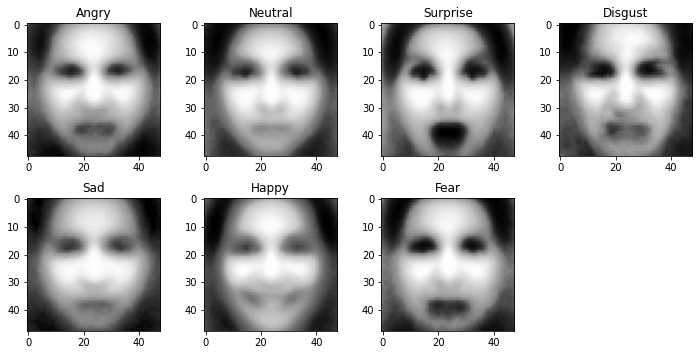

In [16]:
# set plotting options - equalized images for more transparent view
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)

for index, label in enumerate(df['label'].unique()):
    avg_img   = np.stack(df[df['label'] == label]['img_as_matrix']).mean(axis=0).astype(np.uint8)
    
    R, G, B   = cv2.split(avg_img)

    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)

    equ = cv2.merge((output1_R, output1_G, output1_B))
    
    exec(f"ax{index + 1}.imshow(equ)")
    exec(f"ax{index + 1}.set_title(label.title())")
    
fig.tight_layout()

## **Compute the mean error for each image**

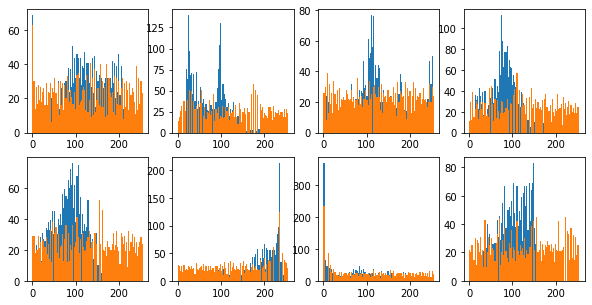

In [17]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(10, 5))

for index, img in enumerate(df['img_as_matrix']):
    # calculate mean value from RGB channels and flatten to 1D array
    img_1_chan = img.mean(axis=2).flatten().astype(np.uint8)
    
    # gett same 
    equ = cv2.equalizeHist(img_1_chan)
    
    exec(f"ax{index + 1}.hist(img_1_chan, bins=100, range=(0, 255))")
    exec(f"ax{index + 1}.hist(equ, bins=100, range=(0, 255))")
    
    if index >= 7:
        break

In [18]:
# store the average image per emotion
average_image_per_label = {}

# compute the average image per label
for index, label in enumerate(df['label'].unique()):
    avg_img = np.stack(df[df['label'] == label]['img_as_matrix']).mean(axis=0).astype(np.int8)
    
    # store the result
    average_image_per_label[label] = avg_img

store deltas between each image and its label's average:

In [19]:
deltas = []

for i in range(len(df)):
    label = df.loc[i, 'label']
    # find the delta between each image and its label's average
    delta = np.absolute(average_image_per_label[label] - df.loc[i, 'img_as_matrix'].astype(np.int8))
    deltas.append(delta)
    
df['delta_vs_avg_image'] = deltas

find the mean error across all channels

In [20]:
df['mean_error'] = df['delta_vs_avg_image'].apply(lambda x: x.mean())

In [21]:
# find an average mean error per group
mean_errors_per_label = df.groupby('label')['mean_error'].mean()

# store standard deviations
error_stds = []

for i in range(len(df)):
    label = df.loc[i, 'label']
    # compute variance between mean error of each image and average error for label
    var = abs(df.loc[i, 'mean_error'] - mean_errors_per_label[label])**2
    # compute standard deviation from variance
    std = np.sqrt(var)
    # store the result
    error_stds.append(std)
    
df['error_std'] = error_stds

In [22]:
df.head()

,path,label,img_as_matrix,delta_vs_avg_image,mean_error,error_std
0,/content/FACE/face/train/angry/Training_980760...,angry,"[[[107, 107, 107], [111, 111, 111], [120, 120,...","[[[9, 9, 9], [2, 2, 2], [8, 8, 8], [21, 21, 21...",43.174045,8.847097
1,/content/FACE/face/train/angry/Training_955648...,angry,"[[[117, 117, 117], [128, 128, 128], [139, 139,...","[[[1, 1, 1], [15, 15, 15], [27, 27, 27], [19, ...",56.172309,4.151166
2,/content/FACE/face/train/angry/Training_788963...,angry,"[[[94, 94, 94], [80, 80, 80], [83, 83, 83], [8...","[[[22, 22, 22], [33, 33, 33], [29, 29, 29], [2...",53.980469,1.959326
3,/content/FACE/face/train/angry/Training_295256...,angry,"[[[150, 150, 150], [88, 88, 88], [102, 102, 10...","[[[34, 34, 34], [25, 25, 25], [10, 10, 10], [9...",48.443142,3.578000
4,/content/FACE/face/train/angry/Training_794049...,angry,"[[[1, 1, 1], [3, 3, 3], [0, 0, 0], [0, 0, 0], ...","[[[115, 115, 115], [110, 110, 110], [112, 112,...",47.598958,4.422184


## **Find whether the mean error is within standard deviation limits**

In [23]:
# compute standard deviation boundaries
min_std = df['error_std'].min()
max_std = df['error_std'].max()


# treat the image as anomalous if its mean error is below or above standard deviation boundaries.
def get_anomalous_point(mean_error: float, min_std: float, max_std: float): return mean_error < min_std or mean_error > max_std
    
# mark images as anomalous or not
df['check_for_anomalies'] = df['mean_error'].apply(lambda err: get_anomalous_point(err, min_std, max_std))

## **If the mean error is below or above the standard deviation boundaries, then we consider the image as anomalous and drop it**

In [24]:
# retrieve indices of the anomalous images to drop
image_indices_to_drop = list(df[df['check_for_anomalies'] == True].index)

# drop anomalous image indices,reset index, and update dataframe
df = df.drop(image_indices_to_drop).reset_index(drop=True)

In [25]:
# print planned to be dropped indices
print(f"How many images gets dropped: {len(image_indices_to_drop)}\nSome samples: {image_indices_to_drop[:20]}\n")

print("Printing first 5 rows from dataframe")
df.head()

How many images gets dropped: 9143
Some samples: [5, 6, 8, 11, 15, 16, 24, 27, 29, 38, 41, 43, 45, 49, 53, 54, 64, 65, 71, 73]

Printing first 5 rows from dataframe


,path,label,img_as_matrix,delta_vs_avg_image,mean_error,error_std,check_for_anomalies
0,/content/FACE/face/train/angry/Training_980760...,angry,"[[[107, 107, 107], [111, 111, 111], [120, 120,...","[[[9, 9, 9], [2, 2, 2], [8, 8, 8], [21, 21, 21...",43.174045,8.847097,False
1,/content/FACE/face/train/angry/Training_955648...,angry,"[[[117, 117, 117], [128, 128, 128], [139, 139,...","[[[1, 1, 1], [15, 15, 15], [27, 27, 27], [19, ...",56.172309,4.151166,False
2,/content/FACE/face/train/angry/Training_788963...,angry,"[[[94, 94, 94], [80, 80, 80], [83, 83, 83], [8...","[[[22, 22, 22], [33, 33, 33], [29, 29, 29], [2...",53.980469,1.959326,False
3,/content/FACE/face/train/angry/Training_295256...,angry,"[[[150, 150, 150], [88, 88, 88], [102, 102, 10...","[[[34, 34, 34], [25, 25, 25], [10, 10, 10], [9...",48.443142,3.578000,False
4,/content/FACE/face/train/angry/Training_794049...,angry,"[[[1, 1, 1], [3, 3, 3], [0, 0, 0], [0, 0, 0], ...","[[[115, 115, 115], [110, 110, 110], [112, 112,...",47.598958,4.422184,False


## **We will handle with an imbalance in the data set**



There are a number of ways to deal with data imbalance:

Over-sampling the under-represented class. However, given the big discrepancy in the counts between such classes as surprise and happy, this method might cause the model to overfit.
Under-sampling the over-represented class. However, this can result in a loss of big amounts of useful data.

SMOTE (Synthetic Minority Oversampling Technique). This method selects examples of data in the feature space (a data point and its nearest neighbor), and then creates a synthetic data point in-between them. In essence, this is an augmentation technique to add varying copies of existing data. We chose to go with this option since we do not want to lose data and do not want to experience the effects of over-fitting.

In [26]:
# view total number of records in dataset
print(f'Length of original dataset is: {len(df)}')

# decrease the dataset to %N samples per each category to solve the memory allocation issue
N_percent       = 0.3

# aggregating storage dataframe
df_agg          = pd.DataFrame(data=[], columns=df.columns)

# per each label, select the first %N samples and append to the aggregating dataframe
for lbl in np.unique(labels):
    len_to_keep = int(N_percent*len(df[df.label == lbl]))
    subset_df   = df[df.label == lbl][:len_to_keep]
    df_agg      = pd.concat([df_agg, subset_df])

# reset index and drop the resulting index column
df_agg          = df_agg.reset_index().drop('index', axis=1)

# view total number of records in the reduced dataset
print(f'Length of reduced dataset is: {len(df_agg)}')

Length of original dataset is: 26744
Length of reduced dataset is: 8020


In [27]:
# view the resulting df
df_agg.head()

,path,label,img_as_matrix,delta_vs_avg_image,mean_error,error_std,check_for_anomalies
0,/content/FACE/face/train/angry/Training_980760...,angry,"[[[107, 107, 107], [111, 111, 111], [120, 120,...","[[[9, 9, 9], [2, 2, 2], [8, 8, 8], [21, 21, 21...",43.174045,8.847097,False
1,/content/FACE/face/train/angry/Training_955648...,angry,"[[[117, 117, 117], [128, 128, 128], [139, 139,...","[[[1, 1, 1], [15, 15, 15], [27, 27, 27], [19, ...",56.172309,4.151166,False
2,/content/FACE/face/train/angry/Training_788963...,angry,"[[[94, 94, 94], [80, 80, 80], [83, 83, 83], [8...","[[[22, 22, 22], [33, 33, 33], [29, 29, 29], [2...",53.980469,1.959326,False
3,/content/FACE/face/train/angry/Training_295256...,angry,"[[[150, 150, 150], [88, 88, 88], [102, 102, 10...","[[[34, 34, 34], [25, 25, 25], [10, 10, 10], [9...",48.443142,3.578000,False
4,/content/FACE/face/train/angry/Training_794049...,angry,"[[[1, 1, 1], [3, 3, 3], [0, 0, 0], [0, 0, 0], ...","[[[115, 115, 115], [110, 110, 110], [112, 112,...",47.598958,4.422184,False


In [28]:
# initialize the SMOTE model
smote = SMOTE(random_state=62)

# assign labels to y
y = df_agg['label']

# X is a list of read-in images
X = np.stack(df_agg['img_as_matrix'])

# get all dimensions of the resulting X
n_samples, height, width, n_channels = [X.shape[index] for index in range(4)]

print(f"Shape of X before reshape: {X.shape}")

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_reshaped = X.reshape(n_samples, n_channels*height*width)

print(f"Shape of X after reshape: {X_reshaped.shape}")



Shape of X before reshape: (8020, 48, 48, 3)
Shape of X after reshape: (8020, 6912)


In [29]:
# perform re-sampling on modified X given y
X_smote, y_smote = smote.fit_resample(X_reshaped, y)

In [30]:
print(f'Before re-sampling, the amount of images:  {len(X):6}')
print(f'After re-sampling, the amount of images:{len(X_smote):10}')

Before re-sampling, the amount of images:    8020
After re-sampling, the amount of images:     14742


<BarContainer object of 7 artists>

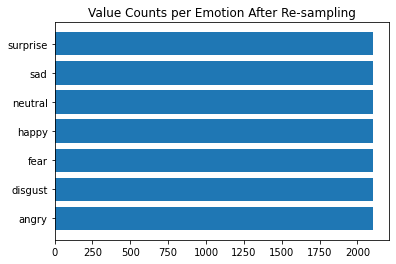

In [31]:
# view the resulting balanced data(modified distribution)
plt.title('Value Counts per Emotion After Re-sampling')
plt.barh(y = y_smote.value_counts().index, width = y_smote.value_counts().values)

# **Dimensionality reduction**


We will look at Principal Component Analysis (PCA), which is a dimensionality reduction technique. We will use it to reduce the feature set size by generating new features that are smaller in size, but still capture the important information.


**There're lots of compression techniques , We chose to use autoencoder:**

## **Autoencoder**

An autoencoder is, by definition, a technique to encode something automatically. By using a neural network, the autoencoder is able to learn how to decompose data (in our case, images) into fairly small bits of data, and then using that representation, reconstruct the original data as closely as it can to the original.

There are two key components in this task:

Encoder: Learns how to compress the original input into a small encoding
Decoder: Learns how to restore the original data from that encoding generated by the Encoder
.

These two are trained together in symbiosis to obtain the most efficient representation of the data that we can reconstruct the original data from, without losing so much of it.



# **Implementing the Autoencoder**



Our data is in the X matrix

Generally in machine learning we tend to make values small, and centered around 0, as this helps our model train faster and get better results, so let's **normalize our images**:



In [32]:
X = X.astype('float32') / 255.0 - 0.5

By now if we test the X array for the min and max it will be -0.5 and 0.5, which you can verify:

In [33]:
print(X.max(), X.min())

0.5 -0.5


To be able to see the image, let's create a show_image function. It will add 0.5 to the images as the pixel value can't be negative:

In [34]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

Now let's take a quick look at our data:

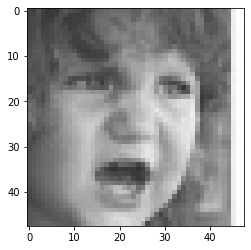

In [35]:
show_image(X[901])

**Now let's split our data into a training and test set:**

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Now time for the model:**

In [37]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

This function takes image_shape (image dimensions) and code_size (the size of the output representation-the vector size).
The function defines the encoder and decodes and returns them.


Now let's connect them together and start our model:


We will set the vector size to 48, a relatively small size, so probably the results did not come out well that is, the images will not be decoded well after encoding.


In [38]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 48)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')



our code variable is the output of the encoder, which we put into the decoder and generate the reconstruction variable.
Afterwards, we link them both by creating a Model with the the inp and reconstruction parameters and compile them with the adamax optimizer and mse loss function.

Compiling the model here means defining its objective and how to reach it. The objective in our context is to minimize the mse and we reach that by using an optimizer - which is basically a tweaked algorithm to find the global minimum.





At this point, we can summarize the results:

In [39]:
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 48)                331824    
                                                                 
 sequential_1 (Sequential)   (None, 48, 48, 3)         338688    
                                                                 
Total params: 670,512
Trainable params: 670,512
Non-trainable params: 0
_________________________________________________________________
None


Here we can see the input is 48,48,3. The None here refers to the instance index, as we give the data to the model it will have a shape of (m, 48,48,3), where m is the number of instances, so we keep it as None.

The hidden layer is 48, which is indeed the encoding size we chose, and lastly the decoder output as you see is (48,48,3).

Now, let's train the model:



We'll be comparing the constructed images to the original ones, so both x and y are equal to X_train. Ideally, the input is equal to the output.



In [ ]:
history = autoencoder.fit(x=x_train, y=x_train, epochs=20,
                validation_data=[x_test, x_test])

We can visualize the loss over epochs to get an overview about the epochs number.



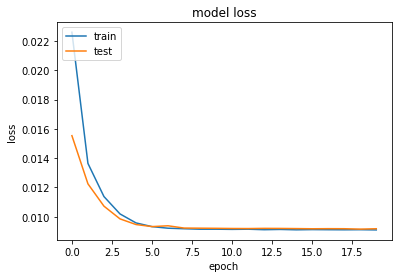

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can see that after the third epoch, there's no significant progress in loss. Visualizing like this can help you get a better idea of how many epochs is really enough to train your model. In this case, there's simply no need to train it for 20 epochs, and most of the training is redundant.

This can also lead to over-fitting the model, which will make it perform poorly on new data outside the training and testing datasets.

Let's visualize the results:



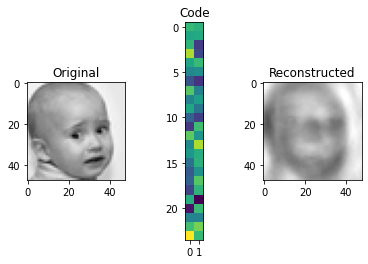

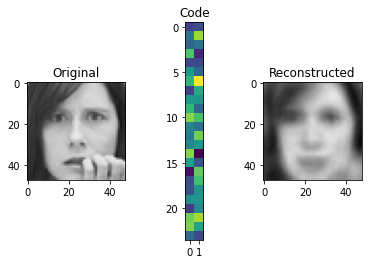

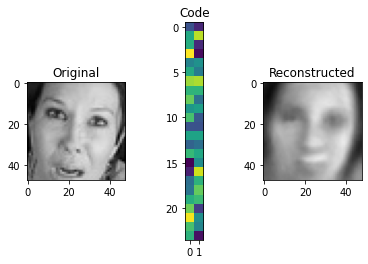

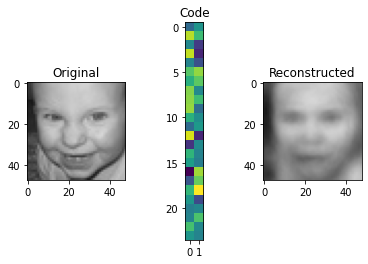

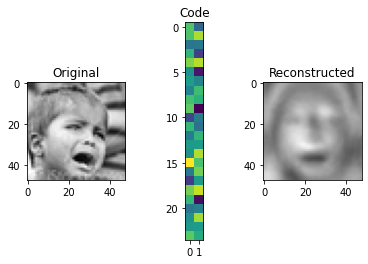

In [42]:
def visualize(img,encoder,decoder,width):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 48, 48, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//width,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder,2)

As we have guessed, you can see that the results are not really good. However, considering that the whole image is encoded in the smallest vector of 48 seen in the middle, this is not bad at all. By compressing from 6912 dimensions to only 48, we lose a lot of data.

Now, let's try again, but now we'll increase the code_size to 1000:



In [43]:
# Same as (48,48,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 1000)              6913000   
                                                                 
 sequential_3 (Sequential)   (None, 48, 48, 3)         6918912   
                                                                 
Total params: 13,831,912
Trainable params: 13,831,912
Non-trainable params: 0
_________________________________________________________________
None


Now, let's re-train the model:


In [ ]:
history_two = autoencoder.fit(x=x_train, y=x_train, epochs=20,
                validation_data=[x_test, x_test])

And let's visualize the results:

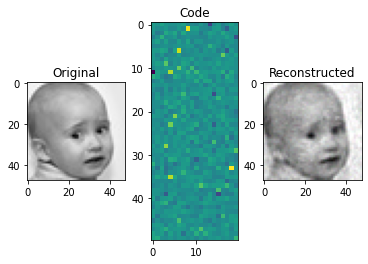

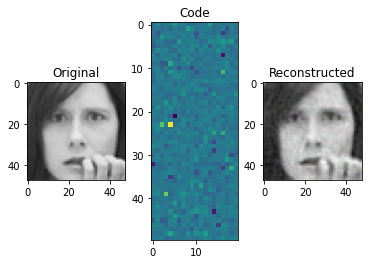

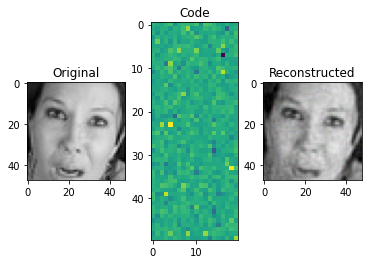

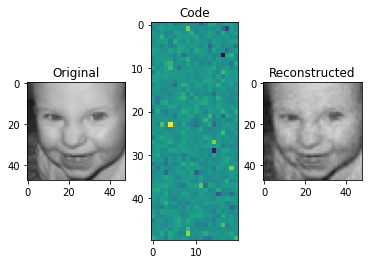

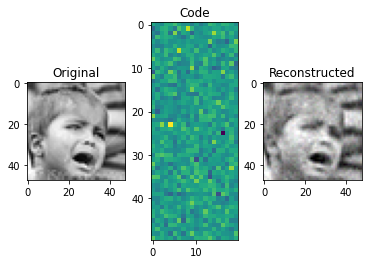

In [45]:
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder,20)

We can see the difference- as we give the model more space to work with, it saves more important information about the image.



**We will now perform the dimensionality reduction for our entire dataset**

In [46]:
def pca_all(img,encoder,decoder):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
    return reco

In [47]:
X_pca = []
for index in range(len(X)):
    img = X[index]
    X_pca.append(pca_all(img,encoder,decoder))

In [48]:
X_pca = np.stack(X_pca)

What we just did is called Principal Component Analysis (PCA), which is a dimensionality reduction technique. We use it to reduce the feature set size by generating new features that are smaller in size, but still capture the important information.



# Image Classification Using MLP Classifier

MLP are the classical type of neural network.

They are comprised of one or more layers of neurons. Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions are made on the output layer, also called the visible layer.

Let's try to run this model on my original data before clearing the data and compare them to the data after clearing the data and dimensionality reduction.

**MLPClassifier on the original data**

In [49]:
# basic imports
import numpy as np   
import pandas as pd
import os

# plotting imports
from matplotlib import pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns 
sns.set()


# model imports
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# metrics import
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Now let's split our **orginal** data into a training and test set:

In [50]:
x_orginal_train, x_orginal_test, y_orginal_train, y_orginal_test = train_test_split(X_orginal, y_orginal, test_size=0.2, random_state=42)

In [51]:
nsamples, nx, ny, nz = x_orginal_test.shape
x_orginal_test = x_orginal_test.reshape((nsamples,nx*ny*nz))

In [52]:
nsamples, nx, ny, nz = x_orginal_train.shape
x_orginal_train = x_orginal_train.reshape((nsamples,nx*ny*nz))

In [53]:
print("Shape of Training Set input variables: {}".format(x_orginal_train.shape))
print("Shape of Training Set outcome variables: {}".format(y_orginal_train.shape))
print("Shape of Test Set input variables: {}".format(x_orginal_test.shape))
print("Shape of Test Set outcome variables: {}".format(y_orginal_test.shape))

Shape of Training Set input variables: (28709, 6912)
Shape of Training Set outcome variables: (28709,)
Shape of Test Set input variables: (7178, 6912)
Shape of Test Set outcome variables: (7178,)


In [ ]:
# build mlp classifier
mlp_model = MLPClassifier(hidden_layer_sizes=[300, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=13, 
                          verbose= True)

# fit the model
%time mlp_model.fit(x_orginal_train, y_orginal_train)

# Save Model!!!!!
import pickle

# save the model to disk
savedModel = 'mlp1_model.save'
pickle.dump(mlp_model, open(savedModel, 'wb'))

In [55]:
# this function takes any model and evaluates it against both training set and dataset
# it prints the following:
#  1. Accuracy Score against trainning set
#  2. Classification report against training set
#  3. Accuracy Score against test set
#  4. Classification report against test set
#  5. Confusion matrix against test set
def evaluate_model( model):
    # predict using the trained model against training dataset
    y_predict_train = model.predict(x_orginal_train)
    
    # predict using the trained model against test dataset
    y_predict_test = model.predict(x_orginal_test)
    
    print("Evaluating Model: MLP")
    print("")
    
    print("1. Accuracy Score (training set) for MLP")
    print(accuracy_score(y_orginal_train, y_predict_train))
    print("")
    
    print("2. Classification Report (training set) for MLP")
    print(classification_report(y_orginal_train, y_predict_train))
    print("")

    print("3. Accuracy Score (test set) for MLP")
    print(accuracy_score(y_orginal_test, y_predict_test))
    print("")

    print("4. Classification Report (test set) for MLP")
    print(classification_report(y_orginal_test, y_predict_test))
    print("")

    print("5. Confusion Matrix for model: MLP")
    cmap = sns.cubehelix_palette(light= 0.9, as_cmap=True)
    cm = confusion_matrix(y_orginal_test, y_predict_test)
    sns.heatmap(cm.T, square = True, annot=True, fmt='d', cbar=False,
               xticklabels= ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy'],
               yticklabels= ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy'], cmap=cmap)
    
    plt.xlabel('True label', size=12)
    plt.ylabel('Predicted label', size=12)
    plt.title('Confusion matrix for model: MLP')


Evaluating Model: MLP

1. Accuracy Score (training set) for MLP
0.3655996377442614

2. Classification Report (training set) for MLP


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

       angry       0.40      0.11      0.17      3948
     disgust       0.00      0.00      0.00       440
        fear       0.25      0.34      0.29      4108
       happy       0.49      0.60      0.54      7183
     neutral       0.37      0.33      0.35      4934
         sad       0.27      0.43      0.33      4885
    surprise       0.69      0.20      0.31      3211

    accuracy                           0.37     28709
   macro avg       0.35      0.29      0.28     28709
weighted avg       0.40      0.37      0.35     28709


3. Accuracy Score (test set) for MLP
0.33212594037336307

4. Classification Report (test set) for MLP
              precision    recall  f1-score   support

       angry       0.30      0.08      0.12      1005
     disgust       0.00      0.00      0.00       107
        fear       0.19      0.28      0.23      1013
       happy       0.48      0.60      0.53      1806
     neutral       0.33      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


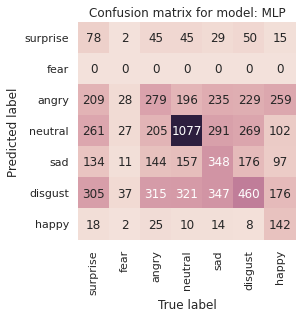

In [56]:
# evaluate the first model against both training and test sets
evaluate_model(mlp_model)

Now, let's run the MLP model on the data that has undergone data clearing and dimensionality reduction.



In [58]:
# X_pca is the clean data after all the cleans
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)



In [59]:
nsamples, nx, ny, nz = x_test.shape
x_test = x_test.reshape((nsamples,nx*ny*nz))

In [60]:
nsamples, nx, ny, nz = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny*nz))

In [61]:
print("Shape of Training Set input variables: {}".format(x_train.shape))
print("Shape of Training Set outcome variables: {}".format(y_train.shape))
print("Shape of Test Set input variables: {}".format(x_test.shape))
print("Shape of Test Set outcome variables: {}".format(y_test.shape))

Shape of Training Set input variables: (6416, 6912)
Shape of Training Set outcome variables: (6416,)
Shape of Test Set input variables: (1604, 6912)
Shape of Test Set outcome variables: (1604,)


In [ ]:
# build mlp classifier
mlp_model = MLPClassifier(hidden_layer_sizes=[200, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=13, 
                          verbose= True)

# fit the model
%time mlp_model.fit(x_train, y_train)


In [63]:
# Save Model!!!!!
import pickle
# save the model to disk
savedModel = 'mlp2_model.save'
pickle.dump(mlp_model, open(savedModel, 'wb'))

In [64]:
# this function takes any model and evaluates it against both training set and dataset
# it prints the following:
#  1. Accuracy Score against trainning set
#  2. Classification report against training set
#  3. Accuracy Score against test set
#  4. Classification report against test set
#  5. Confusion matrix against test set
def evaluate_model( model):
    # predict using the trained model against training dataset
    y_predict_train = model.predict(x_train)
    
    # predict using the trained model against test dataset
    y_predict_test = model.predict(x_test)
    
    print("Evaluating Model: MLP")
    print("")
    
    print("1. Accuracy Score (training set) for MLP")
    print(accuracy_score(y_train, y_predict_train))
    print("")
    
    print("2. Classification Report (training set) for MLP")
    print(classification_report(y_train, y_predict_train))
    print("")

    print("3. Accuracy Score (test set) for MLP")
    print(accuracy_score(y_test, y_predict_test))
    print("")

    print("4. Classification Report (test set) for MLP")
    print(classification_report(y_test, y_predict_test))
    print("")

    print("5. Confusion Matrix for model: MLP")
    cmap = sns.cubehelix_palette(light= 0.9, as_cmap=True)
    cm = confusion_matrix(y_test, y_predict_test)
    sns.heatmap(cm.T, square = True, annot=True, fmt='d', cbar=False,
               xticklabels= ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy'],
               yticklabels= ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy'], cmap=cmap)
    
    plt.xlabel('True label', size=12)
    plt.ylabel('Predicted label', size=12)
    plt.title('Confusion matrix for model: MLP')


    
    

Evaluating Model: MLP

1. Accuracy Score (training set) for MLP
0.9379675810473815

2. Classification Report (training set) for MLP
              precision    recall  f1-score   support

       angry       0.92      0.93      0.93       840
     disgust       0.96      0.95      0.96       105
        fear       0.95      0.90      0.92       902
       happy       0.94      0.96      0.95      1696
     neutral       0.93      0.94      0.93      1069
         sad       0.93      0.93      0.93      1027
    surprise       0.95      0.95      0.95       777

    accuracy                           0.94      6416
   macro avg       0.94      0.94      0.94      6416
weighted avg       0.94      0.94      0.94      6416


3. Accuracy Score (test set) for MLP
0.3877805486284289

4. Classification Report (test set) for MLP
              precision    recall  f1-score   support

       angry       0.33      0.30      0.31       226
     disgust       0.22      0.07      0.11        28
      

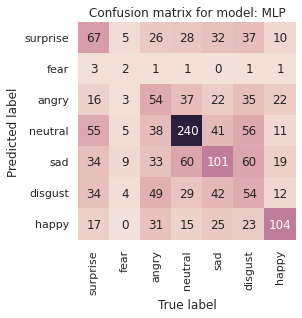

In [65]:
# evaluate the first model against both training and test sets
evaluate_model(mlp_model)

According to the above confusion matrix it seems that it is usually the identification of the class is the most appropriate is the highest, there are notable cases where the model is confused, because there may be similar features but it is not good enough in recognizing these cases. .
As for the fear emotion it seems that the training is not good because there are not many pictures on the fear label. And even in the little that is he did not train it well

It can be seen that after cleaning, the model is more accurate
Accuracy score (training kit)= 0.3655996377442614- Without clearing data.
Vs. Accuracy Score (Training Kit) = 0.9379675810473815- with cleaning.


The test accuracy after clearing the data is 0.3877805486284289,
And is much smaller than train accuracy,

In general, the parameters in the MLP model are greater than the amount of parameters in CNN, so it may be that in MLP we will reach more overfitting. So we will come to a smaller accuracy. Indeed in our model we have seen the low accuracy.

## We will now look at the CNN model and compare its results to the MLP model results:

# **Tensor for the cnn**

# **Separate our training data into features and labels**



For the train / test split the following percentages were chosen: 80%-20%. Of the 80% coming from the train set, 20% is the validation set. Since the data is already balanced, the choice of a random split is a reasonable one.


In [66]:
# # initializing label encoder
# label_encoder = preprocessing.LabelEncoder()

# # convert X and y to Tensors
# X_smote = torch.Tensor(X_smote) # features
# y_smote = label_encoder.fit_transform(y_smote) # targets
# targets = torch.as_tensor(y_smote)


# # split data into train, valid and test
# X_train, X_test, y_train, y_test = train_test_split(X_smote, targets, test_size=0.2, random_state=42)

# initializing label encoder
label_encoder = preprocessing.LabelEncoder()

# convert X and y to Tensors
X_pca = torch.Tensor(X_pca) # features
y = label_encoder.fit_transform(y) # targets
targets = torch.as_tensor(y)


# split data into train, valid and test
X_train, X_test, y_train, y_test = train_test_split(X_pca, targets, test_size=0.2, random_state=42)

In [67]:
# print initial shape of the datasets
print(f"Initial shape of the X datasets along with y:\n\
    {X_train.shape}, {y_train.shape}\n\
    {X_test.shape}, {y_test.shape}\n\
  ")

# reshape to remove the requirements of SMOTE that do not suit standard model training
X_train = X_train.reshape((X_train.shape[0], HEIGHT, WIDTH,3))
X_test = X_test.reshape((X_test.shape[0],HEIGHT, WIDTH,3))

# print latest shape of the datasets
print(f"Latest shape of the X datasets along with y:\n\
    {X_train.shape}, {y_train.shape}\n\
    {X_test.shape}, {y_test.shape}\n\
  ")

Initial shape of the X datasets along with y:
    torch.Size([6416, 48, 48, 3]), torch.Size([6416])
    torch.Size([1604, 48, 48, 3]), torch.Size([1604])
  
Latest shape of the X datasets along with y:
    torch.Size([6416, 48, 48, 3]), torch.Size([6416])
    torch.Size([1604, 48, 48, 3]), torch.Size([1604])
  


In [68]:
# create train, test and validation datasets for the data loader
train_ds = TensorDataset(X_train,y_train)
test_ds = TensorDataset(X_test,y_test)



In [ ]:
X_train.shape

# Quick data visualization

In [69]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48
plt.figure(0, figsize = (12,20))
cpt = 0
plt.tight_layout()

<Figure size 864x1440 with 0 Axes>

# Setup the data generators

In [74]:
from ctypes import resize
from keras.preprocessing.image import ImageDataGenerator


# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow(X_train,y_train, 
                                                    batch_size=batch_size,
                                                    shuffle=True,)

validation_generator = datagen_validation.flow(X_test, y_test,
                                                    batch_size=batch_size,
                                                    shuffle=False)

Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).

# Setup our Convolutional Neural Network (CNN)

We chose to use a Convolutional Neural Network in order to tackle this face recognition problem. Indeed this type of Neural Network (NN) is good for extracting the features of images and is widely used for image analysis subjects like image classification.



A Neural Network is a learning framework that consists in multiple layers of artificial neurons (nodes). Each node gets weighted input data, passes it into an activation function and outputs the result of the function:



A NN is composed of several layers of nodes: *italicized text*

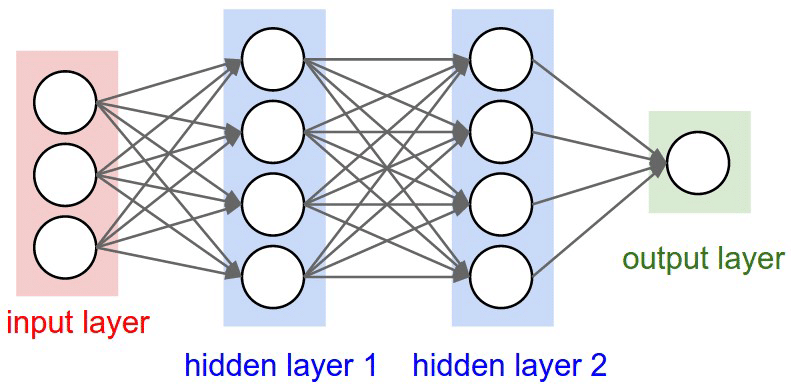

An input layer that will get the data. The size of the input layer depends on the size of the input data.
Some hidden layers that will allow the NN to learn complex interactions within the data. A Neural Network with a lot of hidden layers is called a Deep Neural Network.
An output layer that will give the final result, for instance a class prediction. The size of this layer depends on the type of output we want to produce (e.g. how many classes do we want to predict?)
Classic NNs are usually composed of several fully connected layers. This means that every neuron of one layer is connected to every neurons of the next layer.

Convolutional Neural Networks also have Convolutional layers that apply sliding functions to group of pixels that are next to each other. Therefore those structures have a better understanding of patterns that we can observe in images. We will explain this in more details after.

Now let's define the architecture of our CNN:

In [77]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We define our CNN with the following global architecture:

4 convolutional layers
2 fully connected layers
The convolutional layers will extract relevant features from the images and the fully connected layers will focus on using these features to classify well our images. 

Let's focus on how our convolution layers work. Each of them contain the following operations:

A convolution operator: extracts features from the input image using sliding matrices to preserve the spatial relations between the pixels. The following image summarizes how it works:
The green matrix corresponds to the raw image values. The orange sliding matrix is called a 'filter' or 'kernel'. This filter slides over the image by one pixel at each step (stride). During each step, we multiply the filter with the corresponding elements of the base matrix. There are different types of filters and each one will be able to retrieve different image features:

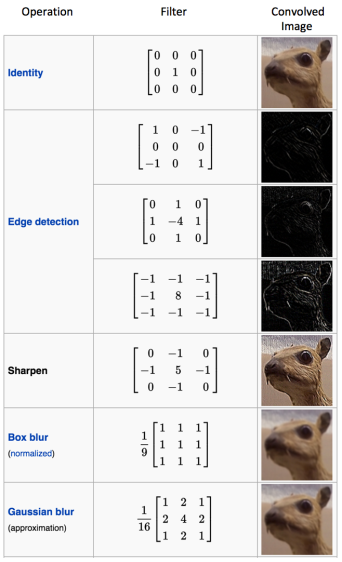

We apply the ReLU function to introduce non linearity in our CNN. Other functions like tanh or sigmoid could also be used, but ReLU has been found to perform better in most situations.
Pooling is used to reduce the dimensionality of each features while retaining the most important information. Like for the convolutional step, we apply a sliding function on our data. Different functions can be applied: max, sum, mean... The max function usually performs better.

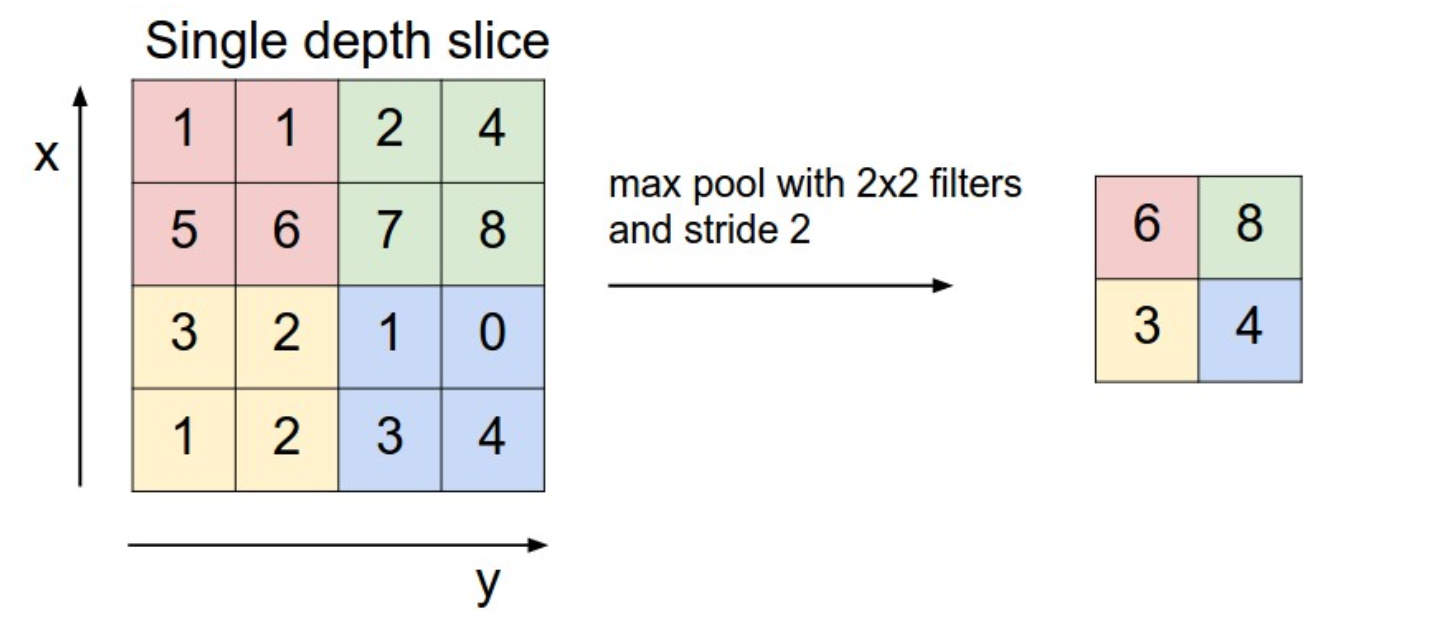

We also use some common techniques for each layer:

Batch normalization: improves the performance and stability of NNs by providing inputs with zero mean and unit variance.
Dropout: reduces overfitting by randomly not updating the weights of some nodes. This helps prevent the NN from relying on one node in the layer too much.
We chose softmax as our last activation function as it is commonly used for multi-label classification.

## **Now that our CNN is defined, we can compile it with a few more parameters. We chose the Adam optimizer as it is one of the most computationally effective. We chose the categorical cross-entropy as our loss function as it is quite relevant for classification tasks. Our metric will be the accuracy, which is also quite informative for classification tasks on balanced datasets.**

## **Train the model**

Everything is set up, let's train our model now!

In [ ]:
# %%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                )

# Save Model!!!!!
import pickle

# save the model to disk
savedModel = 'cnn_model.save'
pickle.dump(model, open(savedModel, 'wb'))
 
# some time later...
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

Our best model managed to obtain a validation accuracy of approximately 65%, which is quite good given the fact that our target class has 7 possible values!

At each epoch, Keras checks if our model performed better than during the previous epochs. If it is the case, the new best model weights are saved into a file. This will allow us to load directly the weights of our model without having to re-train it if we want to use it.

We also have to save the structure of our CNN (layers etc.) into a file:

In [79]:
# serialize model structure to JSON
model_json = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)

## Analyze the results

We got outputs at each step of the training phase. All those outputs were saved into the 'history' variable. We can use it to plot the evolution of the loss and accuracy on both the train and validation datasets:

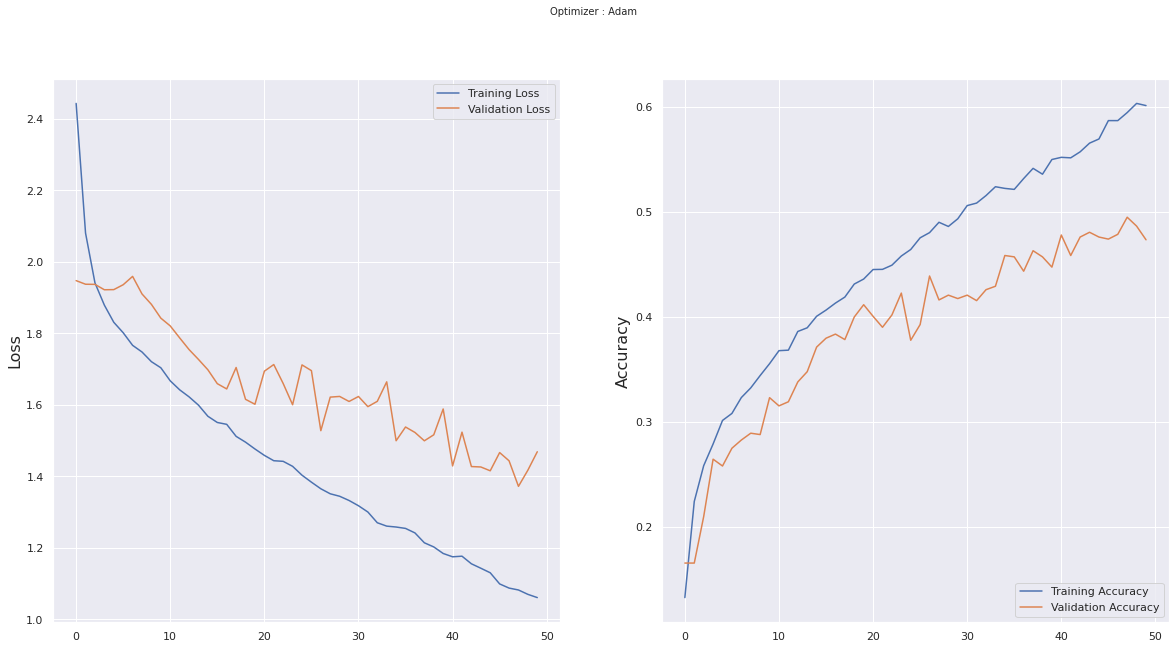

In [80]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

The validation accuracy starts to stabilize at the end of the 50 epochs between 60% and 65% accuracy.

The training loss is slightly higher than the validation loss for the first epochs which can be surprising. Indeed we are more used to see higher validation losses than training losses in machine learning. Here this is simply due to the presence of dropout, which is only applied during the training phase and not during the validation phase.

We can see that the training loss is becoming much smaller than the validation loss after the 20th epochs. This means that our model starts to overfit our training dataset after too much iterations. That is why the validation loss does not decrease a lot after. One solution consists in early-stopping the training of the model.

We could also use some different dropout values and performing data augmentation. Those methods were tested on this dataset, but they did not significantly increase the validation accuracy although they reduced the overfitting effect. Using them slightly increased the training duration of the model.



Our model is very good for predicting happy and surprised faces. However it predicts quite poorly feared faces because it confuses them with sad faces.

With more research and more resources this model could certainly be improved, but the goal of this study was primarily to focus on obtaining a fairly good model compared to what has been done in this field.

### Results of the comparison between the MLP model and CNN
Indeed, according to the accuracy of the cnn, it can be seen that we obtained a higher accuracy than in the mlp model.
It is due to you that the mlp model is local and that is why many times mlp is not suitable for tasks of computer vision and classification.
Compared to cnn which is a less local model and more suitable for this task.

# **resnet50**

Importing the necessary libraries

In [85]:
import tensorflow as tf

# Import The Libraries 

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as p

In [89]:

train_path="/content/FACE/face/train"
test_Path="/content/FACE/face/test"

In [86]:
# Set Resize variable
IMAGE_SIZE = [224, 224] # This is my desired image size... and also ResNet50 accepts image of 224*224.
resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   # 
)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet.summary()

This will let us use the default weights used by the imagenet.

In [90]:
for layer in resnet.layers:
    layer.trainable = False
    

In [94]:
# Usefule for getting number of output classes.
# folders = glob('../input/car-brand-images-dataset/Train/*')
folders = glob(train_path + '/*')

In [92]:
# Set the flatten layer.
x = Flatten() (resnet.output)

In [95]:
prediction = Dense(len(folders), activation = 'softmax')(x)

In [96]:
# Create a model Object
model = Model(inputs = resnet.input, outputs = prediction)

In [ ]:
model.summary()

In [98]:
model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [99]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [101]:
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical' # As we have more than 2 so using categorical.. for 2 we might have used binary.
)

Found 28709 images belonging to 7 classes.


In [102]:
test_set = train_datagen.flow_from_directory(
    test_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical'
)

Found 7178 images belonging to 7 classes.


In [106]:
# fit the model

history = model.fit_generator(
    training_set,
    validation_data = test_set,
    epochs = 10,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set)
)


import pickle

# save the model to disk
savedModel = 'resnet50_model.save'
pickle.dump(model, open(savedModel, 'wb'))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
898/898 [==============================] - 404s 450ms/step - loss: 2.3212 - accuracy: 0.2897 - val_loss: 2.1996 - val_accuracy: 0.3394
Epoch 2/10
898/898 [==============================] - 390s 435ms/step - loss: 2.1914 - accuracy: 0.3063 - val_loss: 1.8136 - val_accuracy: 0.3479
Epoch 3/10
898/898 [==============================] - 403s 449ms/step - loss: 2.1680 - accuracy: 0.3185 - val_loss: 2.0860 - val_accuracy: 0.3948
Epoch 4/10
898/898 [==============================] - 387s 431ms/step - loss: 2.2206 - accuracy: 0.3154 - val_loss: 2.4092 - val_accuracy: 0.3080
Epoch 5/10
898/898 [==============================] - 401s 446ms/step - loss: 2.1662 - accuracy: 0.3293 - val_loss: 2.7548 - val_accuracy: 0.2527
Epoch 6/10
898/898 [==============================] - 384s 428ms/step - loss: 2.3003 - accuracy: 0.3281 - val_loss: 2.2410 - val_accuracy: 0.3174
Epoch 7/10
898/898 [==============================] - 387s 431ms/step - loss: 2.2068 - accuracy: 0.3329 - val_loss: 2.2069 -

Here we run out of GPU and have no way to run again. We will present the RESNET50 results as an image.

In [ ]:
# Plot the Loss

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()


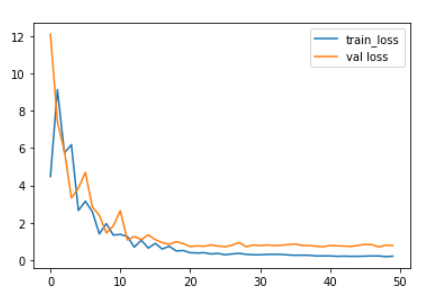

Here it can be seen that the accuracy is much greater than on CNN, because RESNET50 is a pre-trained model that is trained on huge and big data compared to CNN that we train it from start to finish.


In [ ]:
# Plot the Accuracy
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()


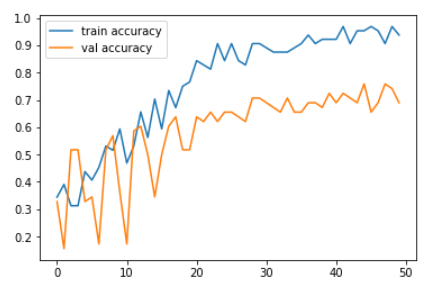

# **In conclusion**

When we approached the task we often debated which topic would be of particular interest to us, recognizing very very expressive expressions attracted us and fascinated us, and despite the difficulties we experienced in dealing with an image database - which is new to us and we researched it from scratch for many months.

We did not know the world of data science at all before this workshop. And now we feel proficient in many thoughtful and interesting topics.

We are excited to present the result to you that we have been working on for many months:

**Summary of the project:**

First, we present to you our data, which are images of facial expressions, divided into seven categories - emotions.

There are many weird ways to clear the data so we can classify the data in the most accurate way, so that the identification is focused and noise-free.

We have chosen to use several techniques for cleaning the data:
Download abnormal images whose average error is below or above the standard deviation limits. About 7,000 photos were removed during this cleanup.
2. We used SMOTE to prevent overfitting.
3. Remove 2/3 of the data to prevent overfitting.
4. We used an Autoencoder model that extracts features from the images and lowers their dimension in order to reduce the storage volume of the data, and to make the training more accurate.

After clearing the data, we selected a number of models for predicting facial expressions:
 1. MLP model - a standard model of keras, we compared its results for running the model on the original data without cleaning, as opposed to running it on the clean data. We have seen the differences between the results.
2. CNN Model- We analyzed its results, and compared its results with MLP results and drew conclusions about the differences between them.
3. RESNET50 - A pre-trained model, we compared its results to the CNN results.


Facial expression recognition can have many and varied uses,

For example, converting facial recognition to an emoji that expresses the facial expression.

We delved a lot into the uses of facial expression recognition and were amazed to discover how much the field can be developed in any direction we want.

This idea particularly fascinates us and we will continue to expand our project after the comments we receive from you and we will know more what to focus on.

We will be happy for comments and reinforcements, and know what is expected of us in terms of project size, and we will be happy to know what to change and add to a perfect project.
Thank you very much for the consideration and for providing the time extension and for the immediate help by email.
Hope you enjoyed the topic we chose and the way it was presented.

### Thank you for the great opportunity! We had a lot of fun and got very smart!🤗🤗